# Deep learning for medical imaging

==============================================================================================
## Practicum 2: Computed Tomography Image Reconstruction
==============================================================================================

In this practicum, you will (1) simulate a simple phantom slice image, (2) apply Radom forward transformation to simulate the computed tomography (CT) projections over an slice (i.e. sinograms) and (3) reconstruct the original phantom intensity values using different image reconstruction algorithms.  

### Aims:
- Understand the principles of CT image reconstruction using a fan beam geometry with the aid of ``skimage``.
- Be able to generate image projections (i.e. sinograms).
- Reconstruct slices from simple and more complex objects (i.e. Shepp–Logan phantom) using back projection and iterative methods.
- Analyse and compare reconstructed data with ground truth data.
- Observe the difference between ideal (noise free) and noisy image reconstruction.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from skimage.transform.radon_transform import _get_fourier_filter

### 2.1 Create a simple and homogeneous phantom (1.5 points)

Create a 2D simple phantom which contains a fake lesion as shown below:

<img src='docs/images_4_notebook/SimplePhantom.png' width="200">

- Phantom size: 256 x 256 pixels.
- Phantom must contain 3 tissues:
    - Background = 0 pixel intensity value
    - Tissue 1 = 1 (radius = 100 pixels)
    - Tissue 2 (lesion) = 2 (radius = 5 pixels)
    
Help: To create the circunferences, you can use the function ``create_circular_mask``, or define your own function. The lesion could be located in any position within the phantom.

Once constructed, plot the original phantom and a pixel intensity (horizontal) profile along the lesion. Always remember to include the units of the axis when ploting a graph.

In [3]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask
# https://newbedev.com/how-can-i-create-a-circular-mask-for-a-numpy-array

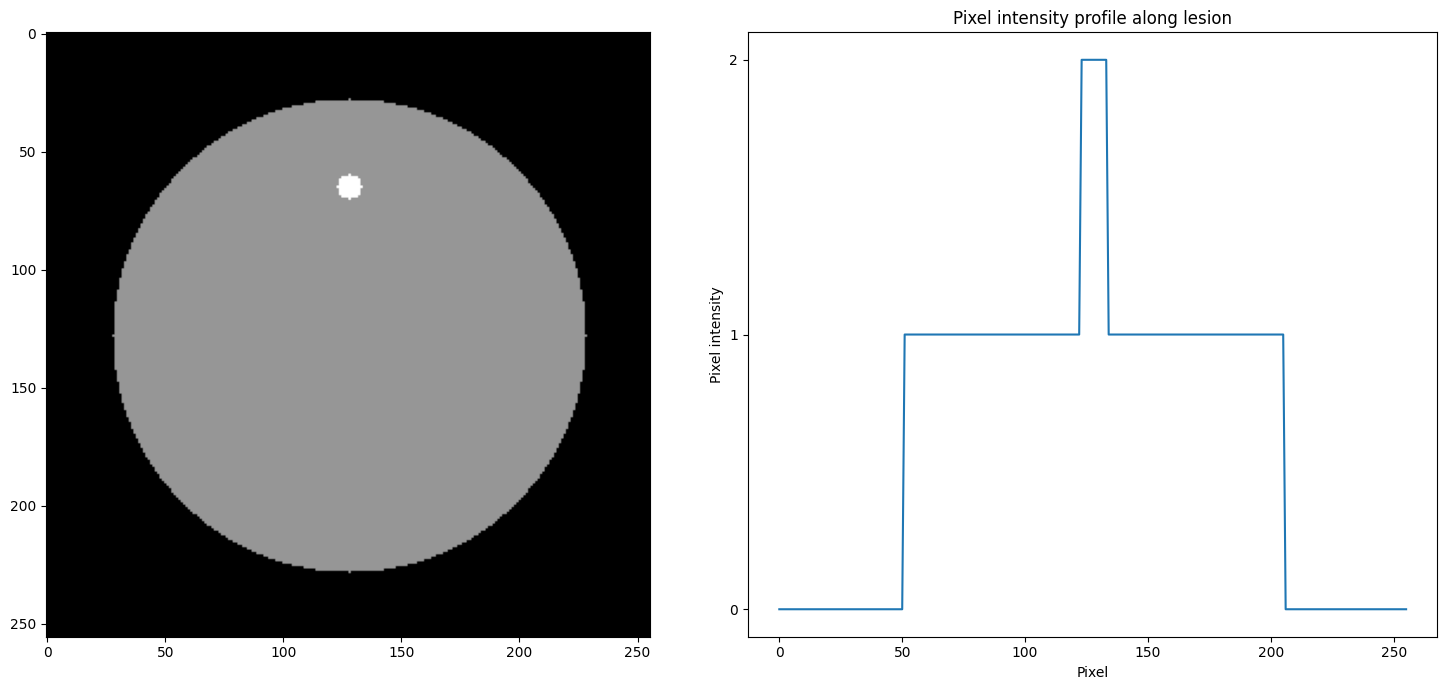

In [4]:
# Create phantom without lesion
phantom = create_circular_mask(256, 256, radius=100)
phantom = phantom.astype(int) # False = 0, True = 1

# Create lesion - size is the minimum one to allocate the circular mask
lesion = create_circular_mask(11, 11, radius=5)
lesion = lesion.astype(int) # False = 0, True = 1

# Summing up phantom + lesion we get Background = 0, Tissue = 1, Lesion = 2
phantom[60:71, 123:134] = phantom[60:71, 123:134] + lesion

# Create figure
rows = 1
columns = 2
fig, axs = plt.subplots(nrows=rows, ncols=columns, figsize=(15, 7))

# Display phantom
axs[0].imshow(phantom, cmap="Greys_r", vmin=0, vmax=2)

# Pixel intensity profile along a random row that has the lesion located in it
axs[1].plot(range(0, 256), phantom[np.random.choice(np.argwhere(phantom==2)[:, 0])], label='Training loss')
axs[1].set_yticks(range(0,3))
axs[1].set_title('Pixel intensity profile along lesion')
axs[1].set_xlabel("Pixel")
axs[1].set_ylabel('Pixel intensity')
        
fig.tight_layout()
plt.savefig('docs/images/phantom_pixel_intensity.png', dpi=500)

### 2.2 Create the projections of the phantom (2 points)

Generate the projections of the previously generated phantom using the ``radon`` transform from ``skimage.transform``. Play with the different parameters to optimise sinogram. Then, show the sinogram of the projections.

In this section, considered the following 2 approches:

``A``. Use different number of projections (i.e. 4, 20, 50, 100, 200, 300, 360) considering that in all cases the simulated projections cover the 360º. For example, 100 projections are taken in the range from 0º to 360º.

``B``. Use different ranges of angles (i.e. 4º, 20º, 50º, 100º, 200º, 300º, 360º) equally distributed.  For instance, 100 projections are taken in a range of 100º.

``Questions``: What is the effect of increasing/decrasing the number of proyections? Can you comment on the difference between approach A and B?

**Case A**: Use a fixed angle range in a different number of projections.

In [5]:
# Select number of projections
number_of_projections = [4, 8, 16, 50, 180, 256, 360]

sinograms_A = [phantom]
thetas_A = []
for n_projections in number_of_projections:
    theta = np.linspace(0, 360, n_projections, endpoint=False) # start = 0, stop = 360, num = n_projections
    sinogram = radon(phantom, theta=theta)
    sinograms_A.append(sinogram)
    thetas_A.append(theta)

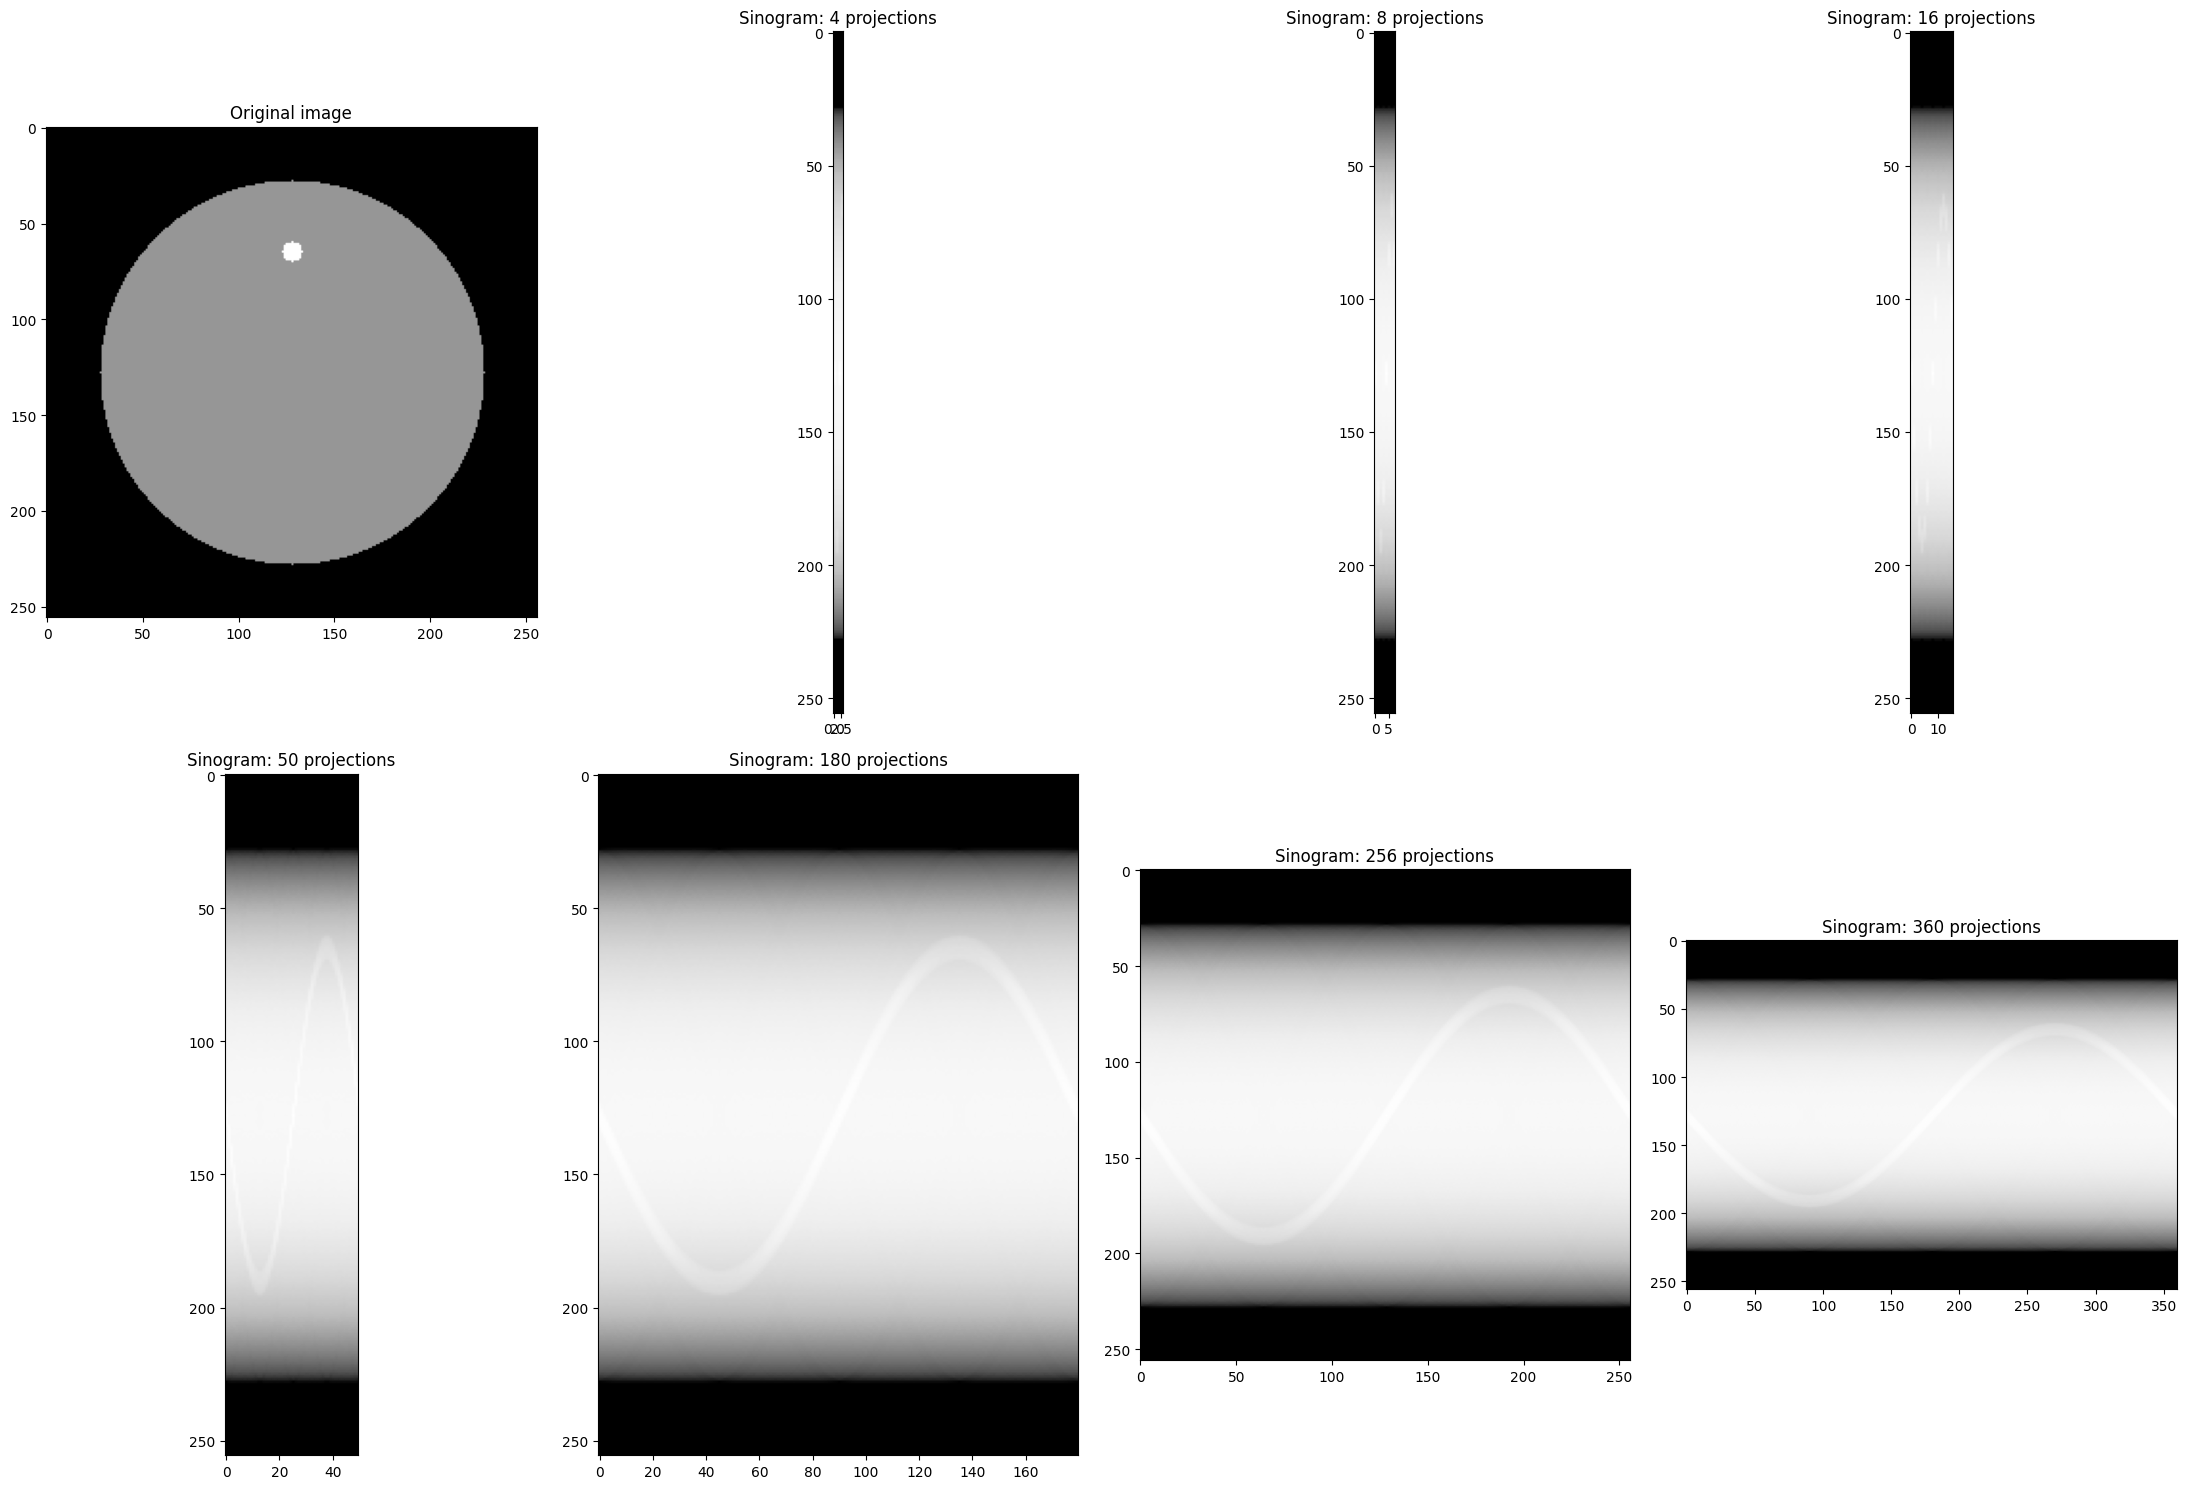

In [6]:
# Setting values to rows and column variables
rows = 2
columns = 4

# Create figure
fig, axs = plt.subplots(nrows=rows, ncols=columns, figsize=(22, 15))

# Plot original image alongside their sinograms
i = 0
for row in range(rows):
    for column in range(columns):
        if i == 0:
            axs[row, column].imshow(sinograms_A[i], cmap="Greys_r", vmin=0, vmax=2)
            axs[row, column].set_title("Original image") 
        else:
            axs[row, column].imshow(sinograms_A[i], cmap="Greys_r")
            axs[row, column].set_title(f"Sinogram: {number_of_projections[i-1]} projections")
        i+=1
        
fig.tight_layout()
plt.savefig('docs/images/sinograms_number_projections.png', dpi=300)

**Case B**: Use a fixed number of projections in different angle ranges. **The number of proyections is, as a rule of thumb, about the same as the number of pixels there are across the object** (i.e. 256 in this case). 

In [7]:
# Select angle ranges (0 - X)
angles = [10, 45, 90, 120, 180, 250, 360]

sinograms_B = [phantom]
thetas_B = []
for angle in angles:
    theta = np.linspace(0, angle, max(phantom.shape), endpoint=False) # start = 0, stop = angle, num = 256
    sinogram = radon(phantom, theta=theta)
    sinograms_B.append(sinogram)
    thetas_B.append(theta)

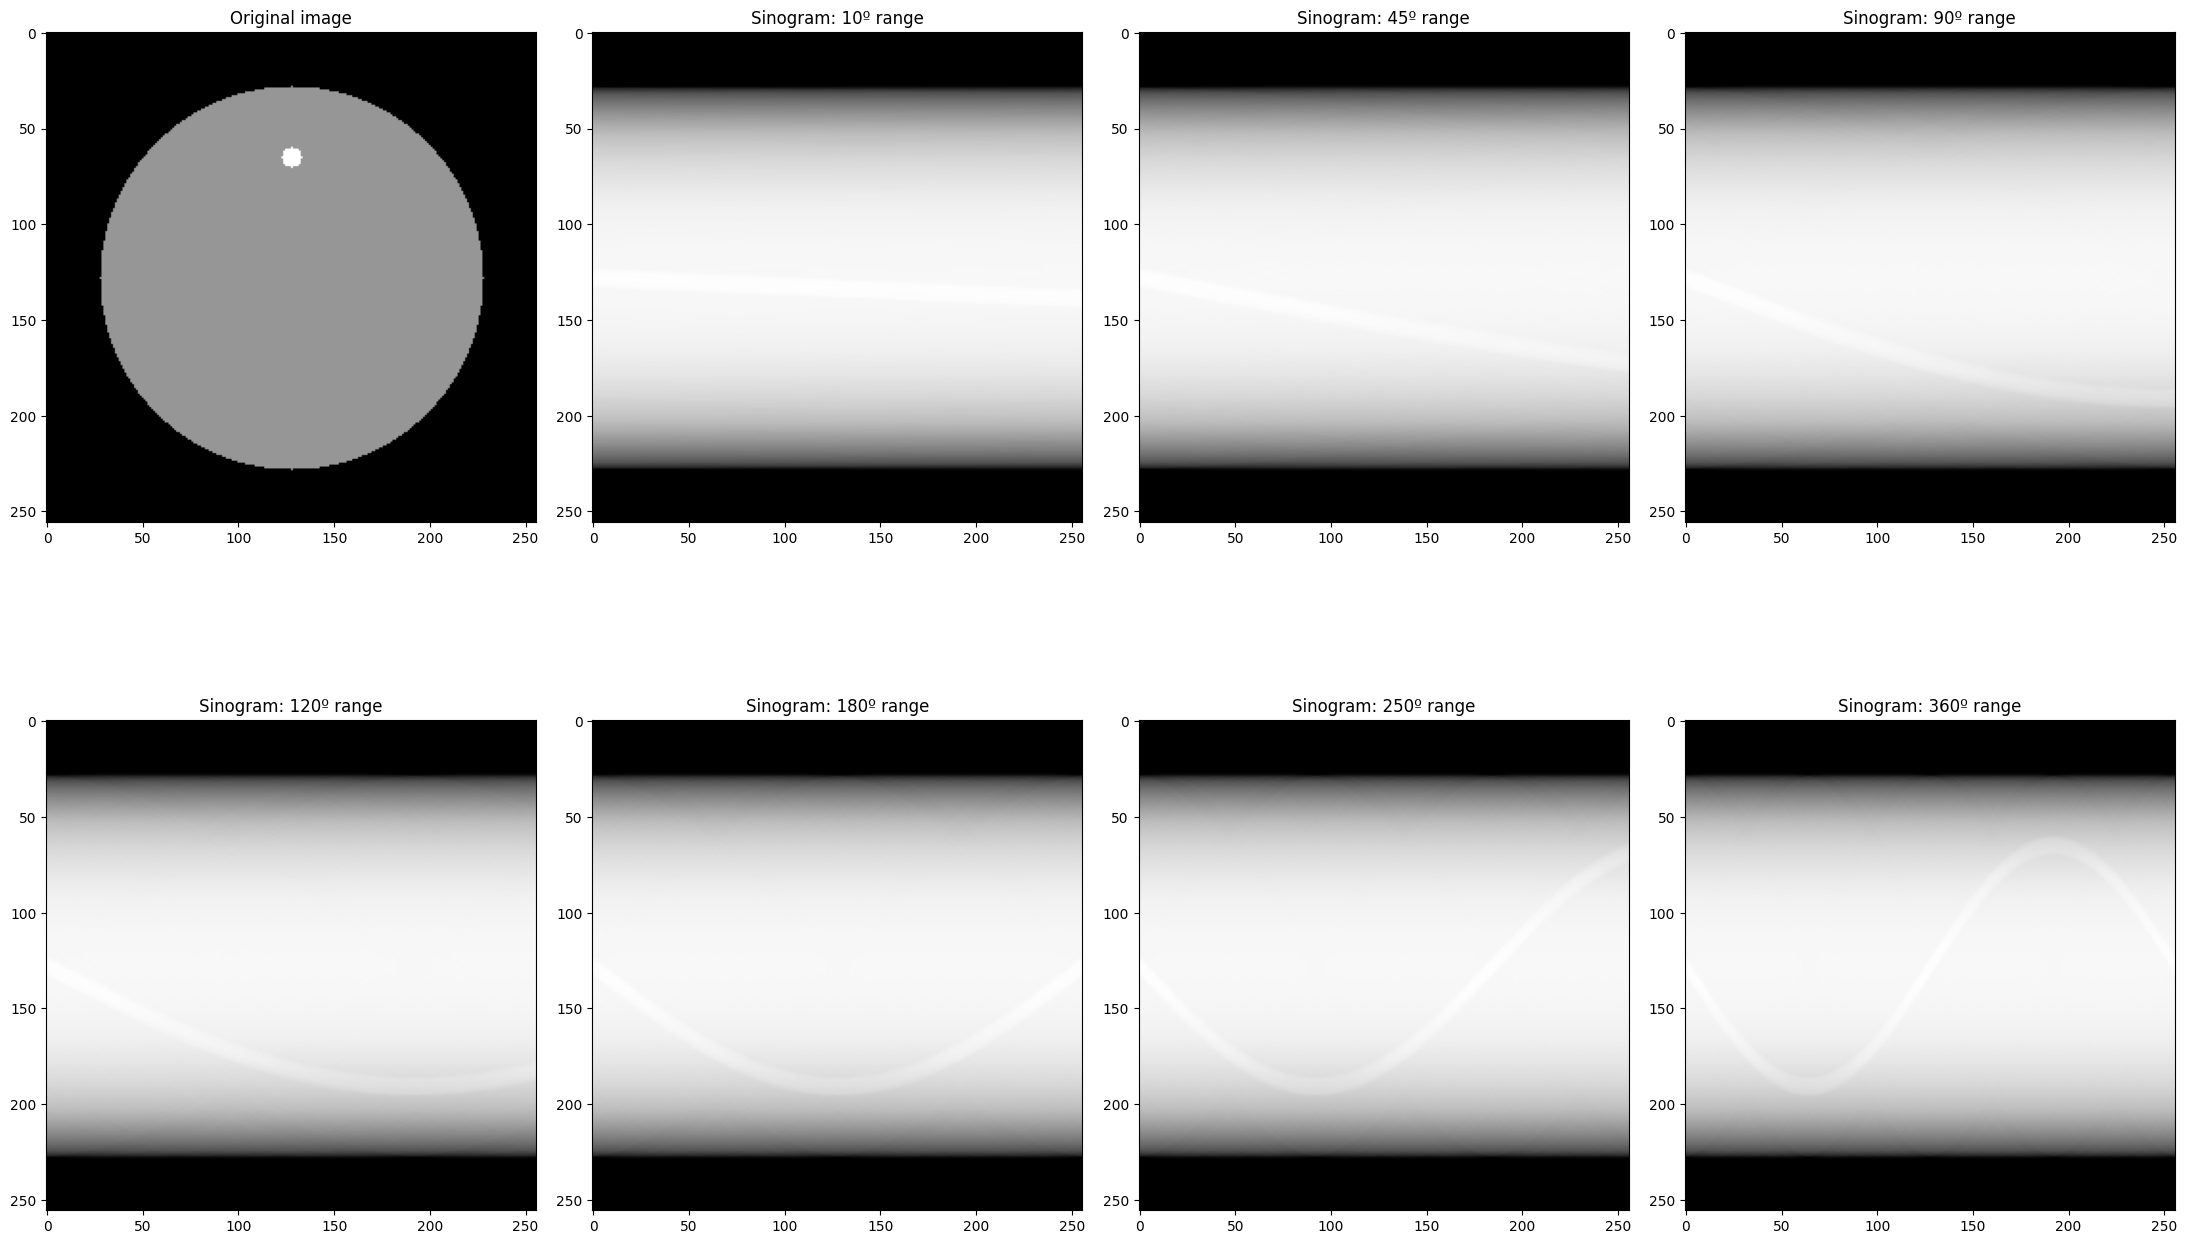

In [8]:
# Setting values to rows and column variables
rows = 2
columns = 4

# Create figure
fig, axs = plt.subplots(nrows=rows, ncols=columns, figsize=(22, 15))

# Plot original image alongside their sinograms
i = 0
for row in range(rows):
    for column in range(columns):
        if i == 0:
            axs[row, column].imshow(sinograms_B[i], cmap="Greys_r", vmin=0, vmax=2)
            axs[row, column].set_title("Original image")     
        else:
            axs[row, column].imshow(sinograms_B[i], cmap="Greys_r")
            axs[row, column].set_title(f"Sinogram: {angles[i-1]}º range")
        i+=1
        
fig.tight_layout()
plt.savefig('docs/images/sinograms_angles.png', dpi=300)

``Question answering``: What is the effect of increasing/decrasing the number of proyections?

The effect of the number of projections **is related to the quality of the desired reconstruction.** Thus, we can see how with each additional projection, we increase the definition of the sinogram. Therefore, **we should consider a sufficient number of projections to be able to reconstruct the original image as faithfully as possible**. As a rule of thumb, the number of projections should be about the same as the number of pixels there are across the object. The reason for this rule is related to the amount of unknown pixel values that must be determined in the reconstruction process in comparison to the number of measurements provided by the projections.

``Comments on  the difference between approach A and B``

Section A uses a variable number of projections within the range 0º - 360º, therefore a complete view of the object is being generated. However, the parameter being varied is the amount of information being taken from it. **The more projections you have, the higher the quality of the reconstruction.** On the other hand, by setting a fixed number of projections and varying the angle we see how this influences the "wave" obtained from the sinogram. In this way, we can see how, for example, **an angle of 180º obtains half a cycle and the amplitude**, which is sufficient to define the reconstruction. For this reason, Radon transform is calculated for angles between 0° and 180° since in this way, the **number of scans of the patience is minimized.**

### 2.3 Reconstruction with Filtered Back Projection (FBP) (2.5 points)

FBP is one of the most simple reconstruction methods to reconstruct images in CT. Explore the ``iradon`` from ``skimage.transform`` using the different filters available (Ramp filter (default), Shepp-logan, Cosine, Hamming, Hann).

Then, show the original and reconstructed images of the phantom.

Explore the two approches (A and B) described previously.

**Filters exploration**

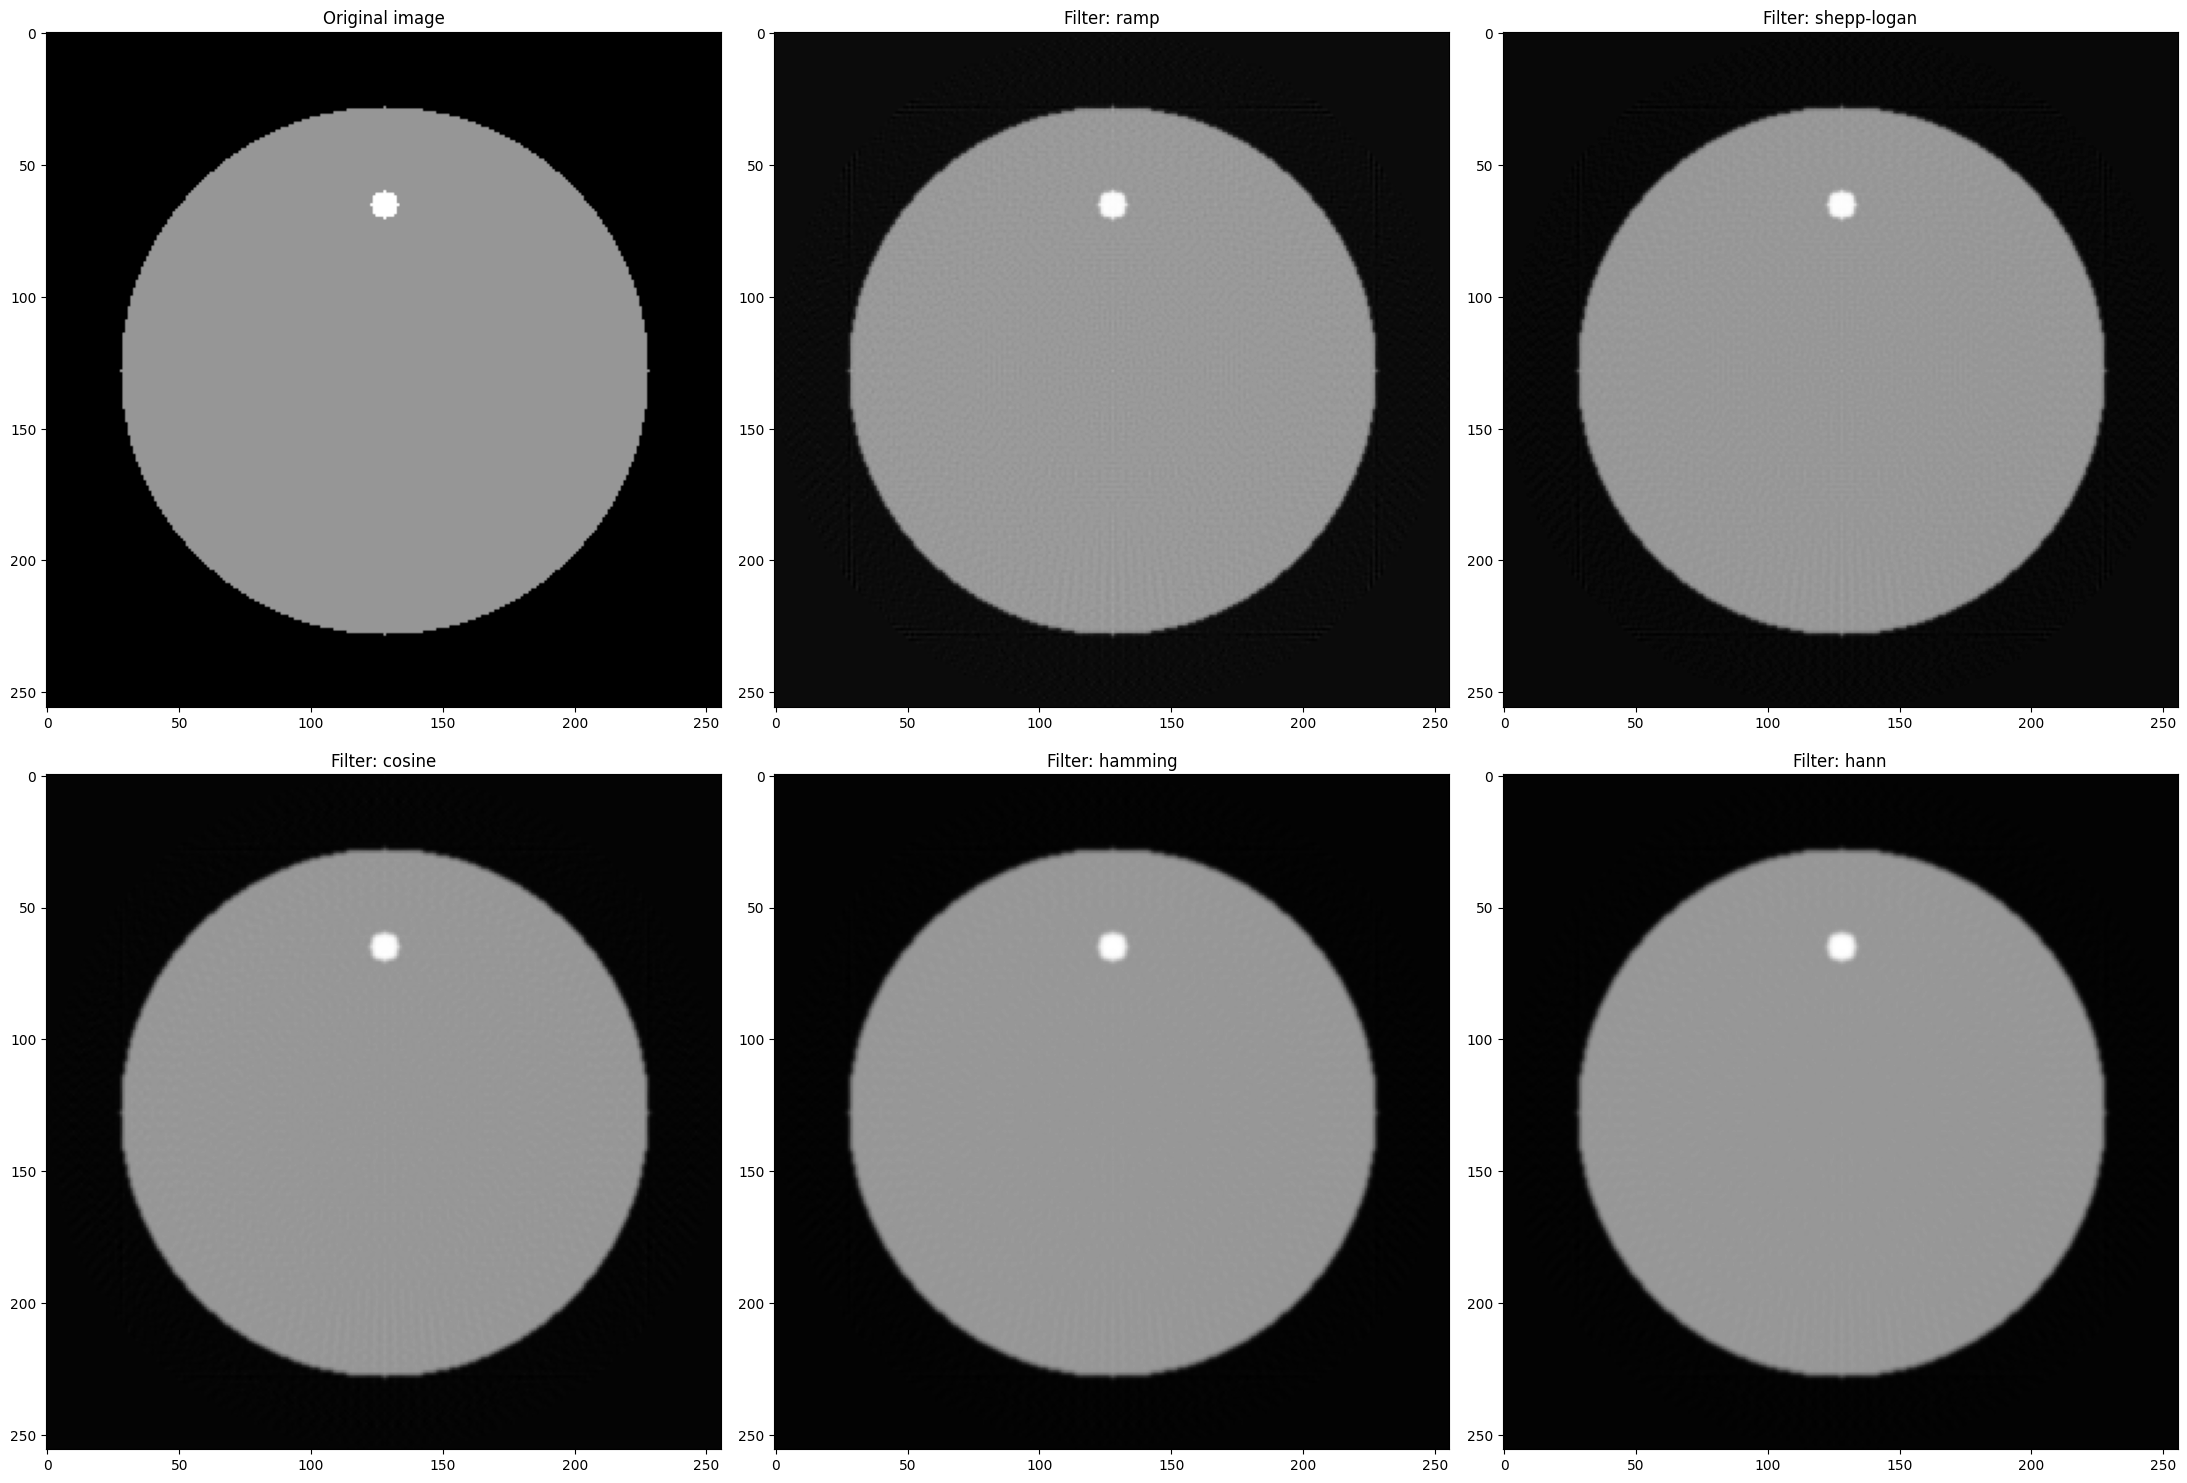

In [9]:
# Select filters to be use
filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']

# Generate sinogram in the range 0º-360º with 256 projections
theta = np.linspace(0, 360, max(phantom.shape), endpoint=False) # start = 0, stop = 360, num = 256
sinogram = radon(phantom, theta=theta)

# Get reconstruction for each filter
reconstructions = []
for filt in filters:
    reconstruction_fbp = iradon(sinogram, theta=theta, filter_name=filt)
    reconstructions.append(reconstruction_fbp)

# Setting values to rows and column variables
rows = 2
columns = 3


# Create figure
fig, axs = plt.subplots(nrows=rows, ncols=columns, figsize=(22, 15))

# Plot original image alongside their sinograms
i = 0
for row in range(rows):
    for column in range(columns):
        if i == 0:
            axs[row, column].imshow(phantom, cmap="Greys_r", vmin=0, vmax=2)
            axs[row, column].set_title("Original image")     
        else:
            axs[row, column].imshow(reconstructions[i-1], cmap="Greys_r")
            axs[row, column].set_title(f"Filter: {filters[i-1]}")
        i+=1
        
fig.tight_layout()
plt.savefig('docs/images/reconstructions_filters.png', dpi=300)

PLOT DE LOS FILTERS 

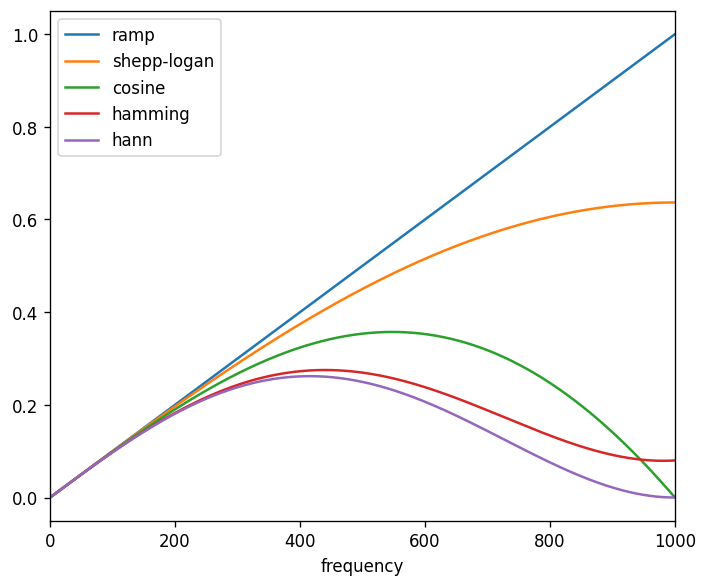

In [10]:
# Create figure
fig = plt.figure(figsize=(6, 5), dpi=120)

# Plot the effects of the different filters
for ix, f in enumerate(filters):
    response = _get_fourier_filter(2000, f)
    plt.plot(response, label=f) 
plt.xlim([0, 1000])
plt.xlabel('frequency')
plt.legend()

fig.tight_layout()
plt.savefig('docs/images/filters_effects.png', dpi=300)

Nos quedamos con.... y reconstruimos A y B

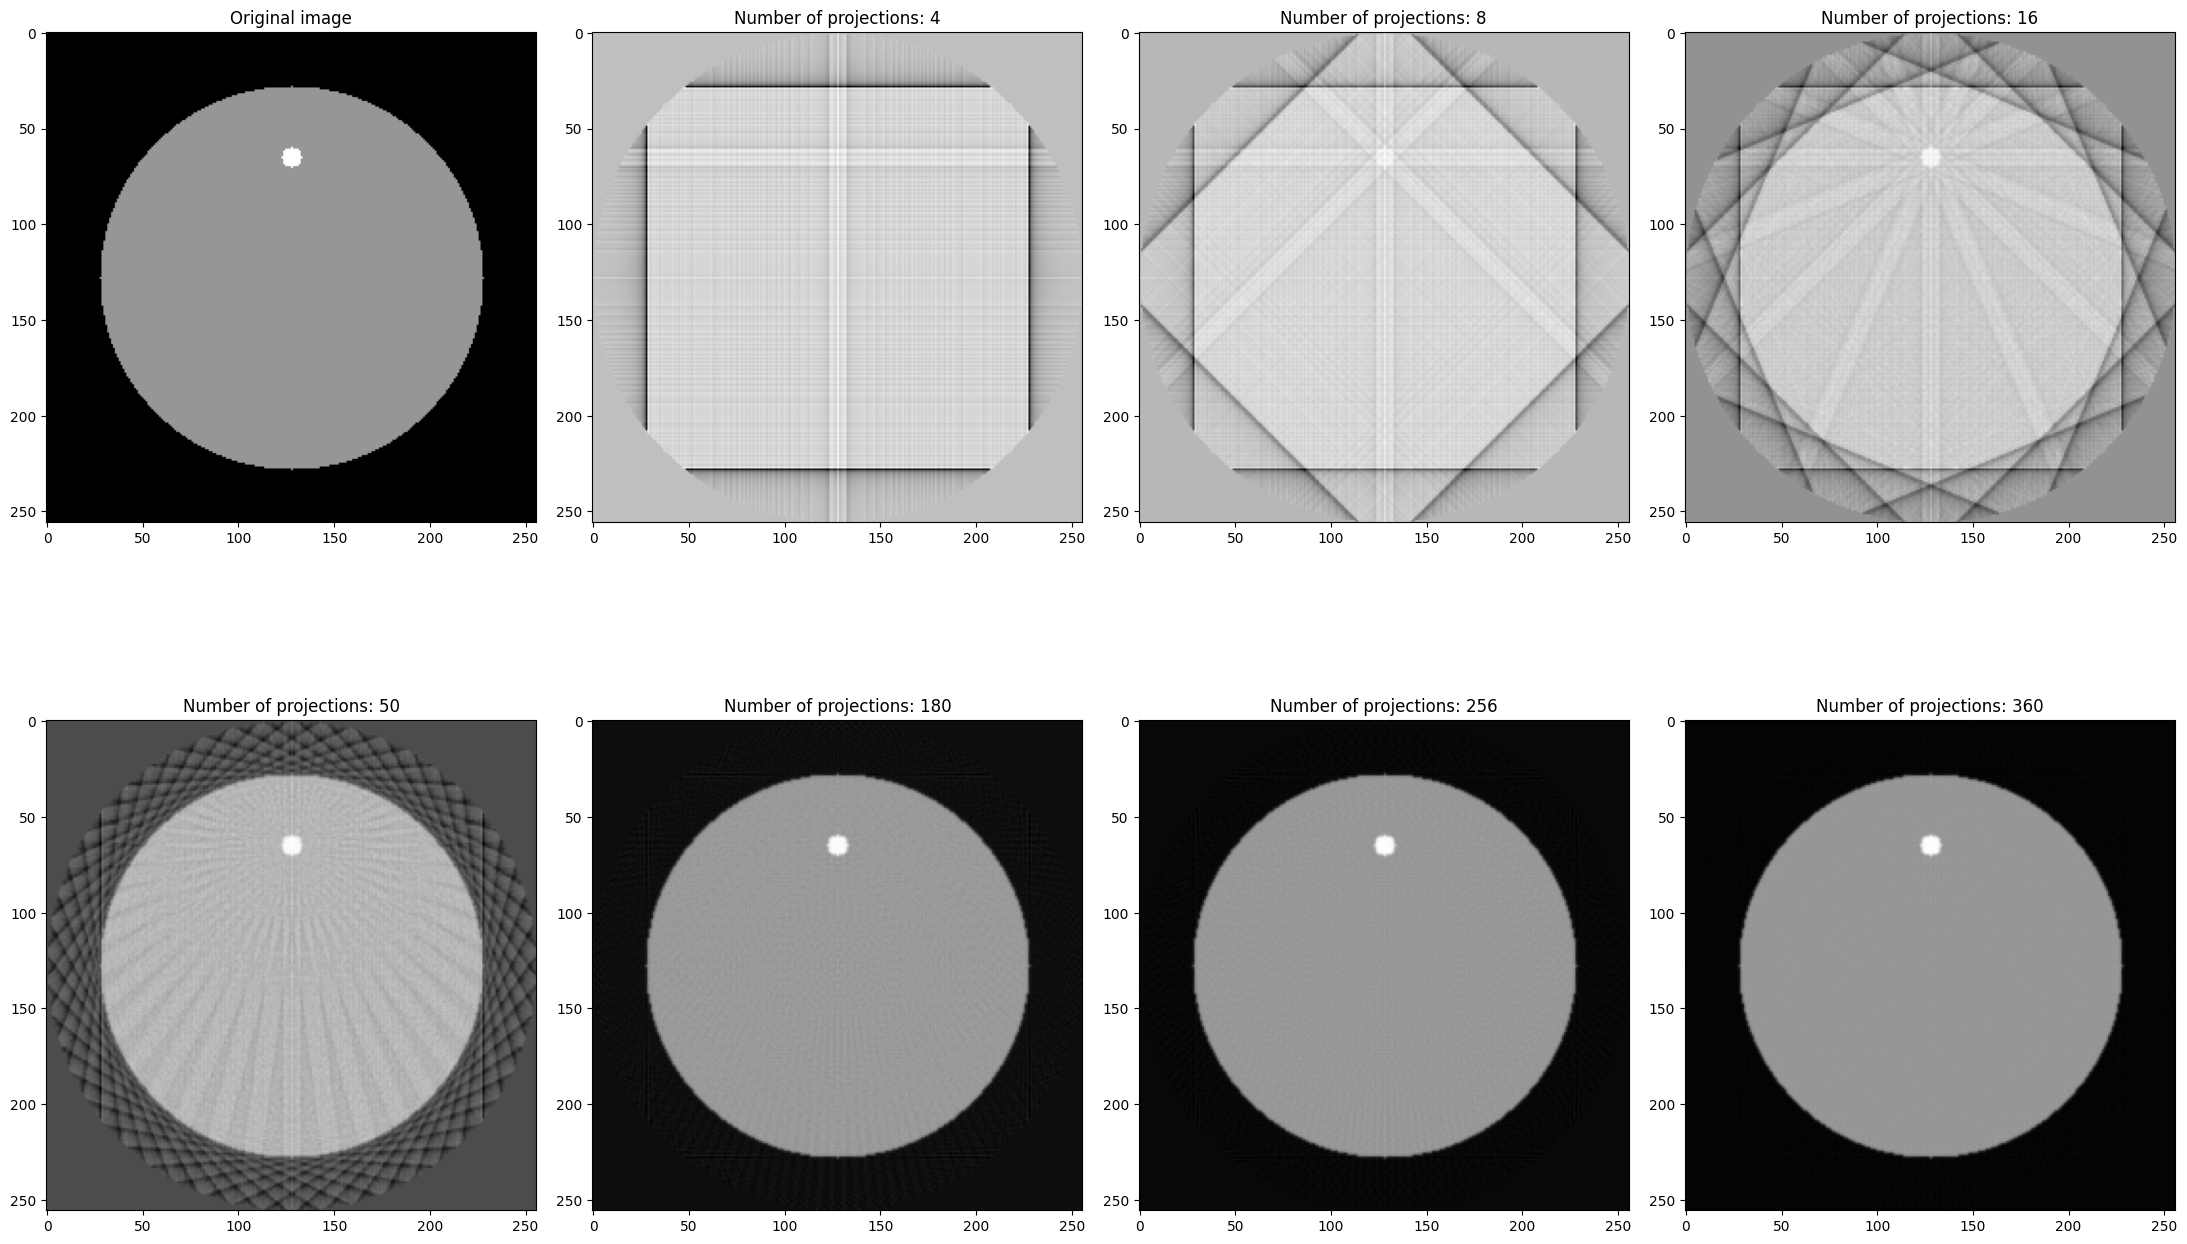

In [11]:
# Get just the sinograms
sinograms = sinograms_A[1:]

# Get reconstruction for the sinogram i with filter shepp-logan
reconstructions = []
for i in range(len(sinograms)):
    reconstruction_fbp = iradon(sinograms[i], theta=thetas_A[i], filter_name='shepp-logan')
    reconstructions.append(reconstruction_fbp)

# Setting values to rows and column variables
rows = 2
columns = 4

# Create figure
fig, axs = plt.subplots(nrows=rows, ncols=columns, figsize=(22, 15))

# Plot original image alongside their sinograms
i = 0
for row in range(rows):
    for column in range(columns):
        if i == 0:
            axs[row, column].imshow(phantom, cmap="Greys_r", vmin=0, vmax=2)
            axs[row, column].set_title("Original image")     
        else:
            axs[row, column].imshow(reconstructions[i-1], cmap="Greys_r")
            axs[row, column].set_title(f"Number of projections: {number_of_projections[i-1]}")
        i+=1
        
fig.tight_layout()
plt.savefig('docs/images/reconstructions_number_projections.png', dpi=300)

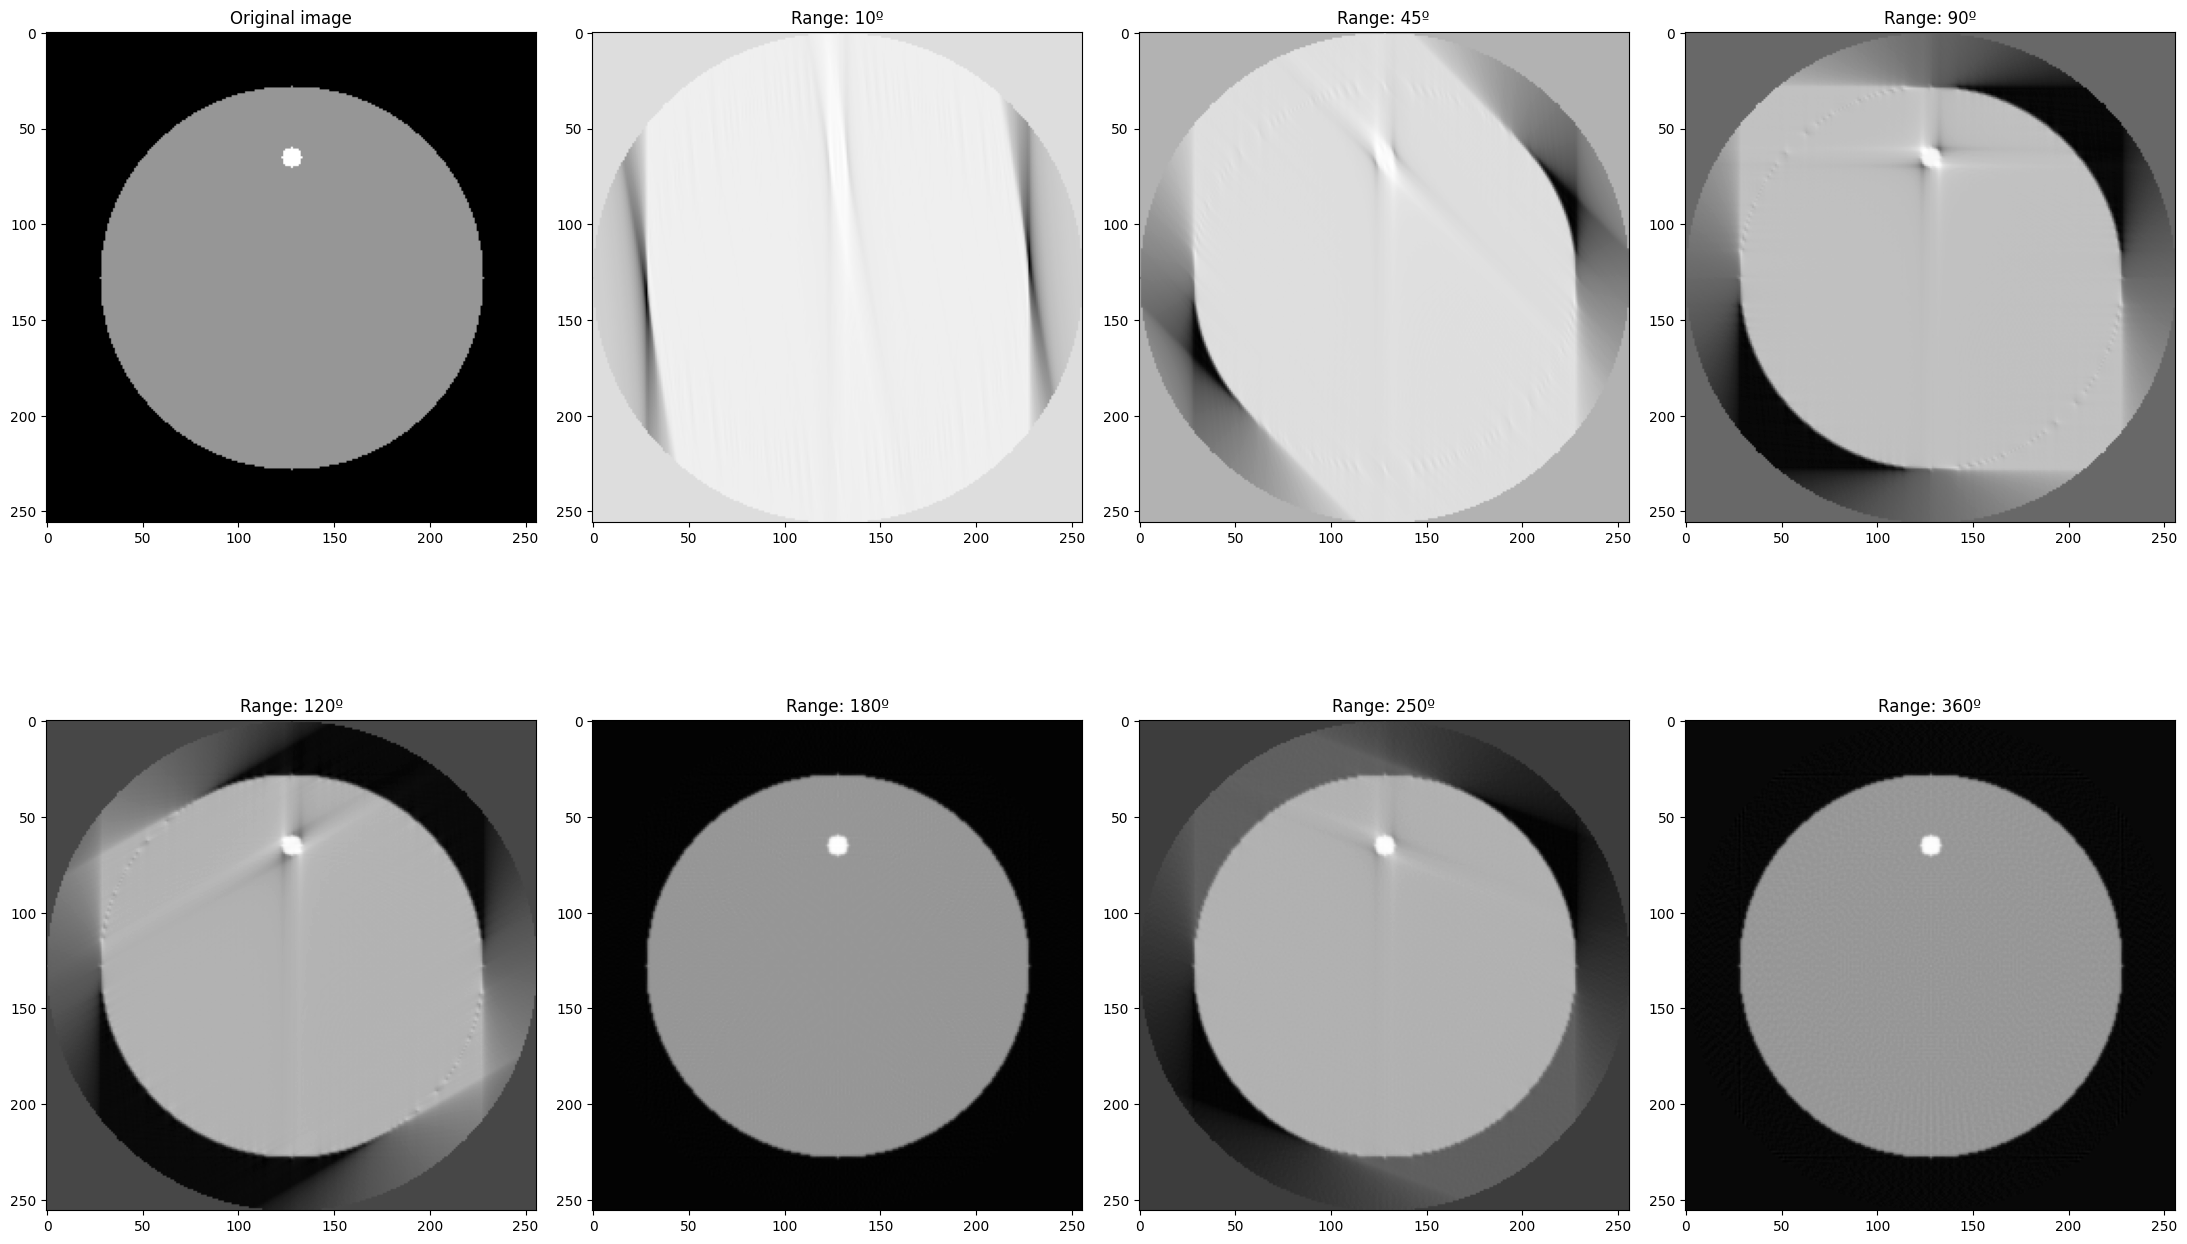

In [12]:
# Get just the sinograms
sinograms = sinograms_B[1:]

# Get reconstruction for the sinogram i with filter shepp-logan
reconstructions = []
for i in range(len(sinograms)):
    reconstruction_fbp = iradon(sinograms[i], theta=thetas_B[i], filter_name='shepp-logan')
    reconstructions.append(reconstruction_fbp)

# Setting values to rows and column variables
rows = 2
columns = 4

# Create figure
fig, axs = plt.subplots(nrows=rows, ncols=columns, figsize=(22, 15))

# Plot original image alongside their sinograms
i = 0
for row in range(rows):
    for column in range(columns):
        if i == 0:
            axs[row, column].imshow(phantom, cmap="Greys_r", vmin=0, vmax=2)
            axs[row, column].set_title("Original image")     
        else:
            axs[row, column].imshow(reconstructions[i-1], cmap="Greys_r")
            axs[row, column].set_title(f"Range: {angles[i-1]}º")
        i+=1
        
fig.tight_layout()
plt.savefig('docs/images/reconstructions_angles.png', dpi=300)

### 2.4 Compare the reconstructed signals (1 points)

Make use of the ``matplotlib`` to compare the original and reconstructed signals. In order to do so, make a single plot with the different pixel intensity profiles of the lesion (as done in 2.1). Then, discuss the results.

In [13]:
# insert your code here



### 2.5 Reconstructing noisy sinograms (2 points)

Add Poison noise (``np.random.poisson``; perhaps with lam = 10) to your previous sinograms and reconstruct the phantom images with the different filters. Plot the reconstruction image and the intensity profile along the lession. Then, comment on the effects of the filters on the reconstructed phatom images.

In [14]:
# insert your code here



### 2.6 Sheep logan phantom (1 point)

So far we have used a quite simple phantom with only 2 tissues. Now, repeat the prior analysis using a (slightly) more advanced head test object, the Sheep-logan phantom. Do you observe particular differences between the reconstrucction results from both phantoms? 


In [15]:
from skimage.data import shepp_logan_phantom

image = shepp_logan_phantom()

# insert your code here